# Image Classification Using Transfer Learning

The VGG11+ batch normalization model with the pre-trained parameters in the torchvision is used for CIFAR10 image classification task.

* Model architecture: VGG11 + batch normalization
* Parameter initialization: pre-trained VGG11 parameters

The following steps are added:
* Data augmentation
* Early stop + Save model

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import vgg11_bn
from torchvision.models.vgg import VGG11_BN_Weights

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
# data augmentation for train data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Check data structure

In [3]:
img, label = next(iter(train_loader))
print(img.shape)

torch.Size([128, 3, 32, 32])


### Sample image

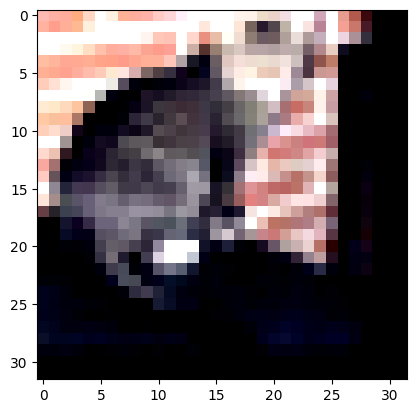

In [4]:
img = img/2 +0.5
plt.imshow(img[0].permute(1,2,0))

#### Model (VGG11 with batch normalization)

In [5]:
# VGG11 + batch normalization
model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

In [6]:
# change 1000 classes classifier to 10 classes classifier
model.classifier[-1] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [7]:
# model inspection
for name, module in model.named_modules():
  if name:
    print(name, module)

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [8]:
# adam optimizer
opt = optim.Adam(model.parameters(),lr =0.001)

# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Learning

In [9]:
num_epochs = 200
train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
# counter for num. of no improvement
num_improv = 0
early_stop = 10

start_time = time.time()

for epoch in range(num_epochs):
  model.train()

  running_train_loss = 0.0
  running_val_loss = 0.0
  running_val_acc = 0.0

  for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
    X, y = data
    X, y = X.to(device), y.to(device)

    opt.zero_grad()
    y_pred = model(X)
    loss = nn.CrossEntropyLoss()(y_pred, y)
    loss.backward()
    opt.step()

    running_train_loss += loss.item()

  with torch.no_grad():
    model.eval()

    for val_batch, val_data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = val_data
      X_val, y_val = X_val.to(device), y_val.to(device)

      y_val_pred = model(X_val)
      running_val_loss += nn.CrossEntropyLoss()(y_val_pred, y_val).item()

      running_val_acc += torch.sum(torch.argmax(y_val_pred, dim=1) == y_val).item()/ y_val.shape[0]

    train_losses.append(running_train_loss/len(train_loader))
    val_losses.append(running_val_loss/len(val_loader))
    val_accuracies.append(running_val_acc/len(val_loader))

    print(f'Epoch : {epoch+1}, train losses {train_losses[-1]: .5f}, val losses {val_losses[-1]: .5f}, val accuracies {val_accuracies[-1]: .5f}')

  # save model and update num. improvement counts
  if val_losses[-1] < best_val_loss:
    best_val_loss = val_losses[-1]
    num_improv =0
    if val_accuracies[-1] > 0.85:
      torch.save(model.state_dict(), f'./model/torch_model_state_dict_checkpoint_epoch{epoch}.pth')

  else:
    num_improv += 1

  # early stop
  if early_stop and num_improv >= early_stop:
    print('Early stopping')
    print(f'Model performance does not improve {early_stop} consecutive epochs')
    idx = val_losses.index(best_val_loss)
    print(f'Best val loss: {best_val_loss: .5f} at epoch {idx}')

    break

end_time = time.time()
print(f'Time to complete {end_time-start_time:.2f} sec')

Epoch : 1, train losses  1.07620, val losses  0.81564, val accuracies  0.74792


Epoch : 2, train losses  0.76104, val losses  0.61286, val accuracies  0.79757


Epoch : 3, train losses  0.64922, val losses  0.54518, val accuracies  0.81379


Epoch : 4, train losses  0.58826, val losses  0.50731, val accuracies  0.83653


Epoch : 5, train losses  0.54399, val losses  0.48020, val accuracies  0.84256


Epoch : 6, train losses  0.50493, val losses  0.45143, val accuracies  0.84840


Epoch : 7, train losses  0.48402, val losses  0.45002, val accuracies  0.85275


Epoch : 8, train losses  0.45625, val losses  0.42515, val accuracies  0.85839


Epoch : 9, train losses  0.43300, val losses  0.45446, val accuracies  0.86165


Epoch : 10, train losses  0.41702, val losses  0.40010, val accuracies  0.87035


Epoch : 11, train losses  0.39243, val losses  0.43671, val accuracies  0.85977


Epoch : 12, train losses  0.38243, val losses  0.41780, val accuracies  0.86294


Epoch : 13, train losses  0.36741, val losses  0.38623, val accuracies  0.87401


Epoch : 14, train losses  0.35652, val losses  0.39906, val accuracies  0.87401


Epoch : 15, train losses  0.35012, val losses  0.42129, val accuracies  0.87451


Epoch : 16, train losses  0.33754, val losses  0.36622, val accuracies  0.88538


Epoch : 17, train losses  0.31713, val losses  0.40515, val accuracies  0.87787


Epoch : 18, train losses  0.30020, val losses  0.37734, val accuracies  0.88113


Epoch : 19, train losses  0.29947, val losses  0.39582, val accuracies  0.88222


Epoch : 20, train losses  0.29802, val losses  0.39384, val accuracies  0.88024


Epoch : 21, train losses  0.28206, val losses  0.37119, val accuracies  0.88647


Epoch : 22, train losses  0.27143, val losses  0.46448, val accuracies  0.87846


Epoch : 23, train losses  0.26931, val losses  0.38540, val accuracies  0.88519


Epoch : 24, train losses  0.25883, val losses  0.38736, val accuracies  0.88786


Epoch : 25, train losses  0.25102, val losses  0.35754, val accuracies  0.89419


Epoch : 26, train losses  0.24718, val losses  0.38550, val accuracies  0.88845


Epoch : 27, train losses  0.22917, val losses  0.39976, val accuracies  0.88598


Epoch : 28, train losses  0.22455, val losses  0.38487, val accuracies  0.88855


Epoch : 29, train losses  0.22343, val losses  0.37784, val accuracies  0.88667


Epoch : 30, train losses  0.21613, val losses  0.45160, val accuracies  0.88123


Epoch : 31, train losses  0.21765, val losses  0.38218, val accuracies  0.88439


Epoch : 32, train losses  0.21513, val losses  0.38978, val accuracies  0.88766


Epoch : 33, train losses  0.21058, val losses  0.39110, val accuracies  0.88489


Epoch : 34, train losses  0.20746, val losses  0.42386, val accuracies  0.88608


Epoch : 35, train losses  0.19597, val losses  0.43686, val accuracies  0.88439
Early stopping
Model performance does not improve 10 consecutive epochs
Best val loss:  0.35754 at epoch 24
Time to complete 1436.19 sec


### Load the best model

In [10]:
# load the best model parameters
idx = val_losses.index(best_val_loss)
model.load_state_dict(torch.load(f'./model/torch_model_state_dict_checkpoint_epoch{idx}.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(f'torch_model_state_dict_checkpoint_epoch{idx}.pth', map_location=torch.device('cpu')))
print('Model is loaded')

<ipython-input-10-cfbcc9afc087>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./model/torch_model_state_dict_checkpoint_epoch{idx}.pth'

Model is loaded


### Model Performance

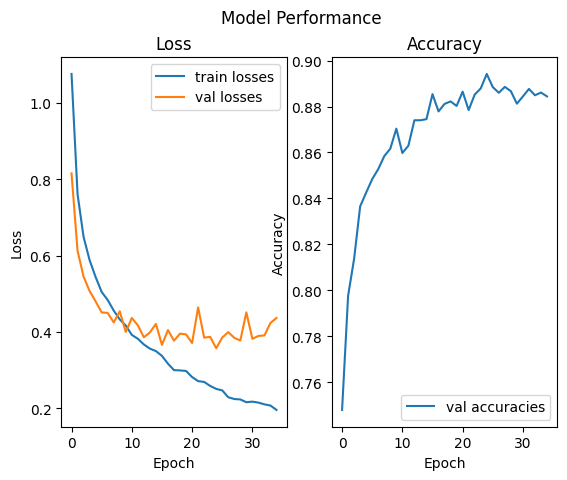

In [22]:
fig, ax = plt.subplots(1,2)
ax[0].plot(train_losses, label = 'train losses')
ax[0].plot(val_losses, label='val losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(val_accuracies, label='val accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
fig.suptitle('Model Performance')
fig.show()

### Model Prediction

In [23]:
from torch.utils.data import Subset
import random

In [24]:
# select random sample from validation dataset
sample_size = 3
choices = random.sample(range(len(val_dataset)), sample_size)
subset = Subset(val_dataset, choices)
subset_loader = DataLoader(subset, batch_size=sample_size, shuffle=False, num_workers=2)

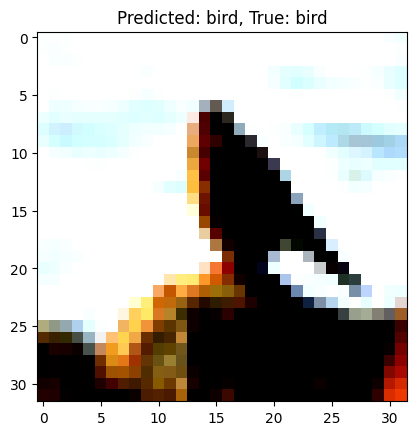

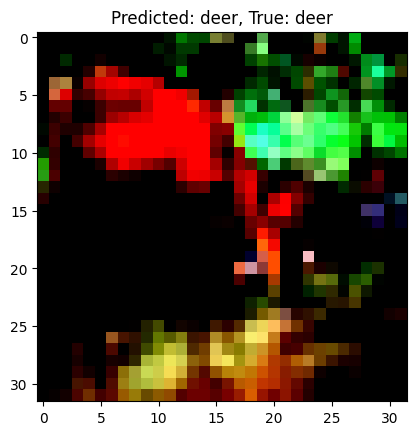

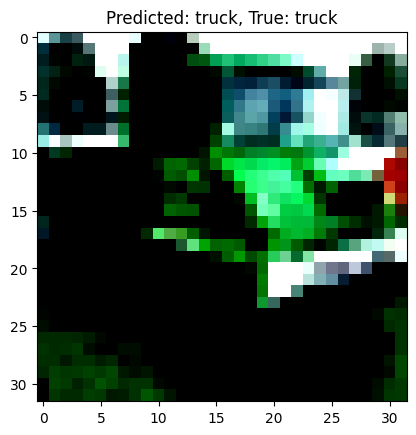

In [28]:
model.eval()

for i, data in enumerate(subset_loader):
  with torch.no_grad():
    x, label = data
    x = x.to(device)
    preds = model(x)
    predicted_class = torch.argmax(preds, dim=1)
    for j in range(len(preds)):
      scaled_image = (x[j] * 255).clamp(0, 255).to(torch.uint8).cpu()
      plt.imshow(scaled_image.permute(1, 2, 0).numpy())
      plt.title(f'Predicted: {classes[predicted_class[j]]}, True: {classes[label[j]]}')
      plt.show()
